In [2]:
import pandas as pd
import numpy as np
import xarray as xr
from pandarallel import pandarallel
import time

import credentials
import hurdat as h
import tc_functions as fun
import plotting_functions as tcplt

In [3]:
storm_data = pd.read_csv('data/filtered_storm_list.csv')
storm_data["DATETIME"] = pd.to_datetime(storm_data["DATETIME"])

In [5]:
def profile_storm(id, storm_data, shear_plt_folder, profiles_folder):
    #for id in unique_storms:
    #id = "AL152016"
    #id = 'AL012015'
    storm = storm_data[storm_data['ID'].str.match(id)]
    storm = storm.reset_index(drop = True)
    vws = []
    centers = []
    profiles = []
    for index, datapoint in storm.iterrows():
        year = datapoint["DATETIME"].year
        month = datapoint["DATETIME"].month
        day = datapoint["DATETIME"].day
        hour = datapoint["DATETIME"].hour

        gfs_data = fun.gfs_access(year, month, day, hour, 
                                    credentials.RDA_USER, credentials.RDA_PASSWORD)
        
        ### TODO: Figure out this whole storm centering thing. 
        # Find center in GFS data using best track as a seed:
        #centers.append(fun.vorticity_centroid(datapoint['LAT'], datapoint['LON'], 
        #                                      pressure = 850, search_radius = 200, calc_radius = 150,
        #                                      dataset = gfs_data))
        centers.append([datapoint['LAT'], datapoint['LON']])

        print("Doing #" + str(index+1) + "/" + str(storm.shape[0]))

        # Get wind shear with vortex removed (only for 2nd datapoint on... we only needed the center location for the 1st datapoint to calculate direction for the 2nd datapoint)
        if index != 0:
            vws.append(fun.shear_stamp(centers[index][0], centers[index][1], 800, gfs_data,
                    vortex_rm = True, vortex_rm_rad = 650))
                    #### CHANGE THIS BACK TO TRUE VORTEX REMOVE!!!

    # Calculate storm direction
    for ii in range(storm.shape[0]-1):
        direction = (round(centers[ii + 1][1] - centers[ii][1], 5), round(centers[ii + 1][0] - centers[ii][0], 5))
        
        if direction == (0, 0):
            vws[ii].attrs['storm_direction'] = (0.01, 0)
        else:
            vws[ii].attrs['storm_direction'] = direction

    # Sectorize according to both storm direction and shear direction, and then calculate radial profiles based on this
    profiles = []
    for ii in range(len(vws)):
        vws[ii] = fun.sectorize(vws[ii], vws[ii].attrs['avg_shear'][0], vws[ii].attrs['avg_shear'][1], "shear")
        vws[ii] = fun.sectorize(vws[ii], vws[ii].attrs['storm_direction'][0], vws[ii].attrs['storm_direction'][1], "velocity")
        profiles.append(fun.radial_profile(vws[ii], stride = 10, h = 35, sector_labels = ["shear", "velocity"]))
        tcplt.shear_map(vws[ii], shear_plt_folder + id + "_" + str(ii) + ".png")

    # Collect all storm info into one xarray DataSet
    stamp_radius = profiles[0].attrs['stamp_radius']
    radius = np.array(profiles[0].radius)
    component = np.array(profiles[0].component)
    sector = np.array(profiles[0].sector)
    time = np.array(storm["DATETIME"])[1:]
    wind = np.array(storm["WIND"])[1:]
    ri = np.array(storm["RI"])[1:]
    rw = np.array(storm["RW"])[1:]
    near_land = np.array(storm["NEAR_LAND"])[1:]
    dist_to_land = np.array(storm["DISTANCE"])[1:]
    center_lat = [profile.attrs['center_lat'] for profile in profiles]
    center_lon = [profile.attrs['center_lon'] for profile in profiles]
    velocity_direction_u = [profile.attrs['sector_velocity_direction'][0] for profile in profiles]
    velocity_direction_v = [profile.attrs['sector_velocity_direction'][1] for profile in profiles]
    shear_direction_u = [profile.attrs['sector_shear_direction'][0] for profile in profiles]
    shear_direction_v = [profile.attrs['sector_shear_direction'][1] for profile in profiles]
    shear_magnitude = np.sqrt(np.power(shear_direction_u, 2) + np.power(shear_direction_v, 2))

    shear_oriented = np.array([profile.values[:,:,0,:] for profile in profiles])
    velocity_oriented = np.array([profile.values[:,:,1,:] for profile in profiles])

    storm_profiles = xr.Dataset(
                    {
                        'shear_oriented': (['time', 'component', 'radius', 'sector'], shear_oriented),
                        'velocity_oriented': (['time', 'component', 'radius', 'sector'], velocity_oriented)
                    },
                    coords = {
                        'time': time,
                        'component': component,
                        'radius': radius,
                        'sector': sector,
                        'ri': ('time', ri),
                        'rw': ('time', rw),
                        'near_land': ('time', near_land),
                        'wind': ('time', wind),
                        'dist_to_land': ('time', dist_to_land),
                        'center_lat': ('time', center_lat),
                        'center_lon': ('time', center_lon),
                        'shear_u': ('time', shear_direction_u),
                        'shear_v': ('time', shear_direction_v),
                        'shear_mag': ('time', shear_magnitude),
                        'velocity_u': ('time', velocity_direction_u),
                        'velocity_v': ('time', velocity_direction_v)  
                    },
                    attrs = {
                        'long_name': "Set of all radial profiles for an entire storm.",
                        'storm_id': id,
                        'stamp_radius': stamp_radius
                    }
    )

    storm_profiles.to_netcdf(profiles_folder+"prof_"+id+".nc")

In [6]:
shear_plt_folder = "/glade/work/galenv/shear_figs/"
profiles_folder = "/glade/work/galenv/shear_profiles/"

#shear_plt_folder = "figures/"
#profiles_folder = "data/profiles/"

unique_storms = pd.Series(np.unique(storm_data['ID']))

In [7]:
print("Getting GFS data warmup...")
gfs_data = fun.gfs_access(2016, 12, 12, 0, credentials.RDA_USER, credentials.RDA_PASSWORD)
print("GFS data has been gotten! On to the parallel")

Getting GFS data warmup...
GFS data has been gotten! On to the parallel


In [8]:
time.sleep(3)

In [ ]:
print("Setting up parallel env.")
pandarallel.initialize()
print("Parallel env set up... starting parallel computations.")
unique_storms.parallel_apply(profile_storm, args = (storm_data, shear_plt_folder, profiles_folder))
print("All done!")

In [11]:
###### Extract data from profiles for EDA
import xarray as xr
import pandas as pd
import numpy as np
import os

In [111]:
test = xr.open_dataset('data/profiles_vortex/prof_AL012015.nc')

In [114]:
test.center_lon.values

array([282.7, 282.5, 282.2])

In [33]:
data = pd.DataFrame(columns=['storm', 'wind', 'RI', 'shear'])
ii = 1
for filename in os.listdir('data/profiles_vortex/'):
    f = xr.open_dataset('data/profiles_vortex/' + filename)
    data = data.append( pd.DataFrame( np.column_stack( ( ii*np.ones(f.wind.values.size), f.wind.values, f.ri.values, f.shear_mag.values ) ), columns=['storm', 'wind', 'RI', 'shear'] ), ignore_index = True )
    ii += 1
        

In [36]:
data.to_csv("storms_summary.csv", index=False)

In [93]:
import cartopy.crs as ccrs       # cartopy 0.18.0
import cartopy.feature 

import matplotlib.pyplot as plt  # matplotlib 3.3.0
import matplotlib.ticker as mticker

In [123]:
lonlat = []
for filename in os.listdir('data/profiles_vortex/'):
    f = xr.open_dataset('data/profiles_vortex/' + filename)
    lat = f.center_lat.values
    lon = f.center_lon.values
    lon[lon > 180] = lon[lon > 180] - 360 
    lonlat.append(np.array([lon, lat]))

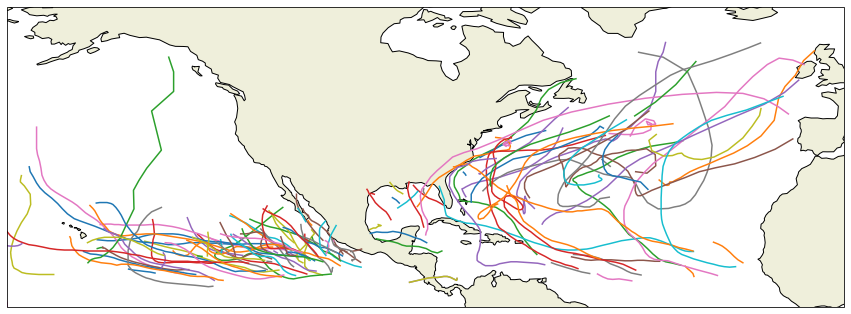

In [138]:
central_lat = 37.5
central_lon = -96
extent = [-171, 0, 5, 10]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
#ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor = 'black')
#ax.add_feature(cartopy.feature.LAKES, edgecolor = 'black')
for x in lonlat:   
    ax.plot(x[0], x[1], transform = ccrs.Geodetic())